# Property regression example

## low level interface

To show how the components of NFFLr work together, let's train a formation energy model using the `dft_3d` dataset.
We can use the `periodic_radius_graph` transform to configure the `AtomsDataset` to automatically transform atomic configurations into `DGLGraph`s.

In [17]:
from nfflr.data.dataset import AtomsDataset
from nfflr.data.graph import periodic_radius_graph
dataset = AtomsDataset(
    "dft_3d", 
    target="formation_energy_peratom", 
    transform=periodic_radius_graph
)
dataset[0]

dataset_name='dft_3d'
Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


(Graph(num_nodes=8, num_edges=288,
       ndata_schemes={'Xfrac': Scheme(shape=(3,), dtype=torch.float32), 'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}),
 tensor(-0.4276))

Set up a medium-sized ALIGNN model:

In [18]:
from nfflr.models.gnn import alignn
cfg = alignn.ALIGNNConfig(
    alignn_layers=2, 
    gcn_layers=2, 
    norm="layernorm", 
    atom_features="embedding"
)
model = alignn.ALIGNN(cfg)

atoms, target = dataset[0]
model(atoms)

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


tensor(-0.4640, grad_fn=<SqueezeBackward0>)

In [33]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler

train_ids = np.random.choice(dataset.split["train"], 100 * 16)

train_loader = DataLoader(
    dataset,
    batch_size=16, 
    collate_fn=dataset.collate, 
    sampler=SubsetRandomSampler(train_ids),
    drop_last=True
)
next(iter(train_loader))

(Graph(num_nodes=158, num_edges=4790,
       ndata_schemes={'Xfrac': Scheme(shape=(3,), dtype=torch.float32), 'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}),
 tensor([-0.5353,  0.4825,  0.5219, -2.2870,  0.0086, -0.5814, -0.4578, -0.6456,
         -0.6809, -0.8549, -1.8560,  0.3077, -1.8425, -2.6277, -0.6696, -1.6628]))

Now we can set up a PyTorch optimizer and objective function and optimize the model parameters with an explicit training loop. See the [PyTorch quickstart tutorial for more context)[https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html].

In [37]:
from tqdm import tqdm

In [38]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.1)

training_loss = []
for step, (g, y) in enumerate(tqdm(train_loader)):
    pred = model(g)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    training_loss.append(loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


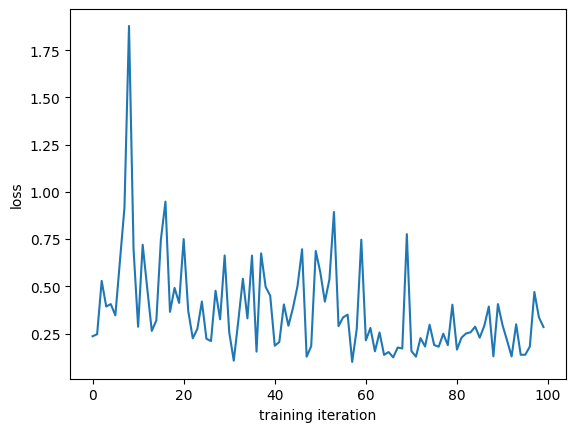

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(training_loss)
plt.xlabel("training iteration")
plt.ylabel("loss");